# Page rank Google web

## Import package

In [12]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt 

## Membaca data dari file .txt

In [2]:
df = pd.read_csv('dataset/web-Google_10k.txt', 
                 delim_whitespace=True, 
                 header=None, 
                 names=['FromNodeId', 'ToNodeId'], 
                 comment='#') # Baris yang diawali '#' (seperti deskripsi) diabaikan

C:\Users\willy\AppData\Local\Temp\ipykernel_15732\2736022564.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('dataset/web-Google_10k.txt',


## Fungsi Manual

In [3]:
def pagerank(adj_matrix, d=0.85, max_iter=100, tol=1e-6):
    """
    Hitung PageRank dari matriks adjacency.
    
    Parameters:
        adj_matrix : array-like, shape (n, n)
            Matriks adjacency (1 jika ada link i -> j)
        d : float
            Damping factor (default: 0.85)
        max_iter : int
            Maksimum iterasi
        tol : float
            Toleransi konvergensi
    
    Returns:
        r : ndarray, shape (n,)
            Vektor PageRank
    """
    adj = np.array(adj_matrix, dtype=float)
    n = adj.shape[0]
    
    # Tangani dangling nodes (baris dengan jumlah 0)
    out_degree = np.sum(adj, axis=1)
    for i in range(n):
        if out_degree[i] == 0:
            adj[i, :] = 1.0  # taut ke semua halaman
    
    # Normalisasi baris → jadi matriks transisi (baris jumlah = 1)
    # TAPI: PageRank asli menggunakan TRANSPOSE → aliran masuk
    # Jadi kita transpos untuk membuat kolom = out-link
    M = adj / np.sum(adj, axis=1, keepdims=True)
    M = M.T  # Sekarang M[j,i] = probabilitas dari i ke j
    
    # Inisialisasi
    r = np.ones(n) / n
    teleport = (1 - d) / n
    
    for _ in range(max_iter):
        r_new = d * M @ r + teleport
        if np.linalg.norm(r_new - r, 1) < tol:
            break
        r = r_new
    
    return r


### 2. Mapping node ID menjadi index

In [4]:
# Membuat index unik untuk node
nodes = pd.Index(sorted(set(df['FromNodeId']).union(set(df['ToNodeId']))))
node_to_index = {node: i for i, node in enumerate(nodes)}

# Mapping ke index
df['from_index'] = df['FromNodeId'].map(node_to_index)
df['to_index'] = df['ToNodeId'].map(node_to_index)
print(df.head())


   FromNodeId  ToNodeId  from_index  to_index
0           0     11342           0       373
1           0    824020           0      8822
2           0    867923           0      9377
3           0    891835           0      9661
4       11342         0         373         0


### Buat adjacency matrix

In [5]:
n = len(nodes)
adj_matrix = lil_matrix((n, n))

for _, row in df.iterrows():
    adj_matrix[row['from_index'], row['to_index']] = 1

adj_matrix = adj_matrix.toarray()


### Hitung PageRank

In [6]:
pr = pagerank(adj_matrix)
print("Top 10 PageRank scores:")
top_nodes = pr.argsort()[-10:][::-1]
for idx in top_nodes:
    print(f"Node ID asli {nodes[idx]} punya PageRank = {pr[idx]:.6f}")


Top 10 PageRank scores:
Node ID asli 486980 punya PageRank = 0.006999
Node ID asli 285814 punya PageRank = 0.004748
Node ID asli 226374 punya PageRank = 0.003396
Node ID asli 163075 punya PageRank = 0.003331
Node ID asli 555924 punya PageRank = 0.002686
Node ID asli 32163 punya PageRank = 0.002383
Node ID asli 828963 punya PageRank = 0.002190
Node ID asli 504140 punya PageRank = 0.002148
Node ID asli 396321 punya PageRank = 0.002114
Node ID asli 599130 punya PageRank = 0.002104


### 6. Export PageRank ke CSV

In [ ]:
# result = pd.DataFrame({
#     "node_index": range(len(nodes)),
#     "node_id_asli": nodes,
#     "pagerank": pr
# })
# result.to_csv("pagerank_result.csv", index=False)
# print("\n✅ Hasil PageRank disimpan ke pagerank_result.csv")


✅ Hasil PageRank disimpan ke pagerank_result.csv


## Menggunakan fungsi Network

### Membuat Graph Terarah

In [8]:
G = nx.from_pandas_edgelist(df, 'FromNodeId', 'ToNodeId', create_using=nx.DiGraph())

### Menghitung PageRank

In [9]:
pagerank_scores = nx.pagerank(G, alpha=0.85)

### Mengubah hasil PageRank menjadi DataFrame

In [ ]:
pagerank_df = pd.DataFrame(list(pagerank_scores.items()), 
                        columns=['NodeId', 'PageRank'])

### Mengurutkan DataFrame berdasarkan PageRank (dari terbesar ke terkecil)

In [15]:
pagerank_sorted = pagerank_df.sort_values(by='PageRank', ascending=False)

top_10_nodes = pagerank_sorted.head(10)

# 3. Menampilkan hasilnya
print("10 Node dengan PageRank Tertinggi:")
print(top_10_nodes)

10 Node dengan PageRank Tertinggi:
      NodeId  PageRank
994   486980  0.006515
3849  285814  0.004633
113   226374  0.003301
2847  163075  0.003288
5214  555924  0.002756
3522   32163  0.002366
626   828963  0.002270
1557  599130  0.002136
3534  396321  0.002121
1274  504140  0.002098


## Visualisasi Grafik

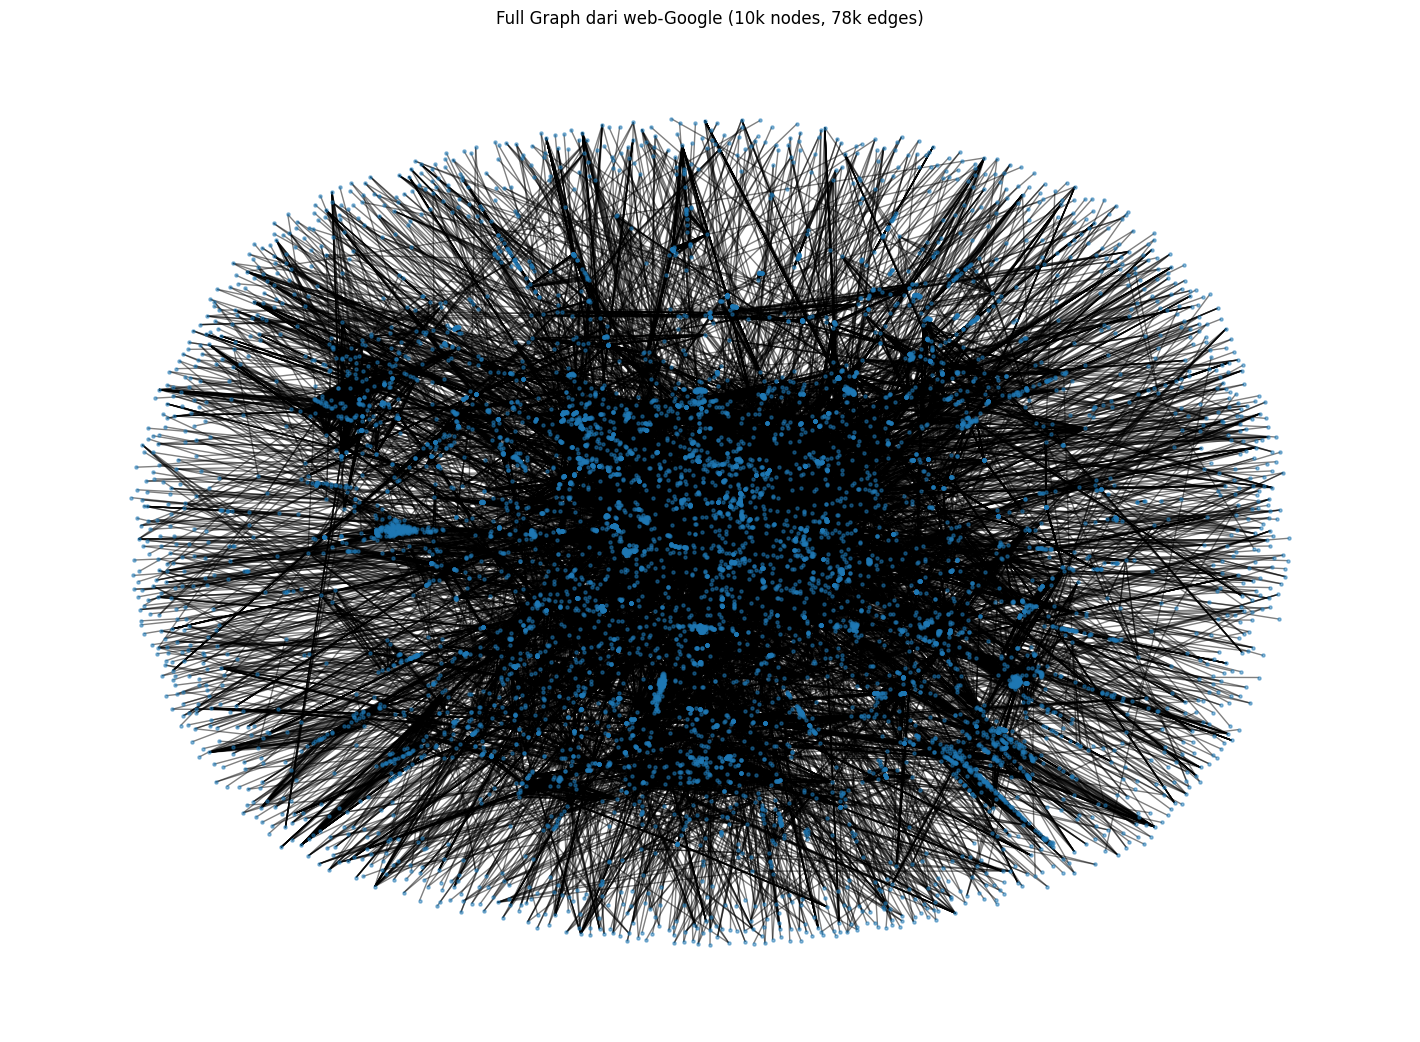

In [ ]:
# Plot semua node dan edge (WARNING: sangat berat)
G = nx.from_pandas_edgelist(df, 'from_index', 'to_index', create_using=nx.DiGraph())
plt.figure(figsize=(14, 10))
nx.draw(G, node_size=5, arrows=False, alpha=0.5)
plt.title("Full Graph dari web-Google (10k nodes, 78k edges)")
plt.show()

### Plot 10 PageRank Teratas

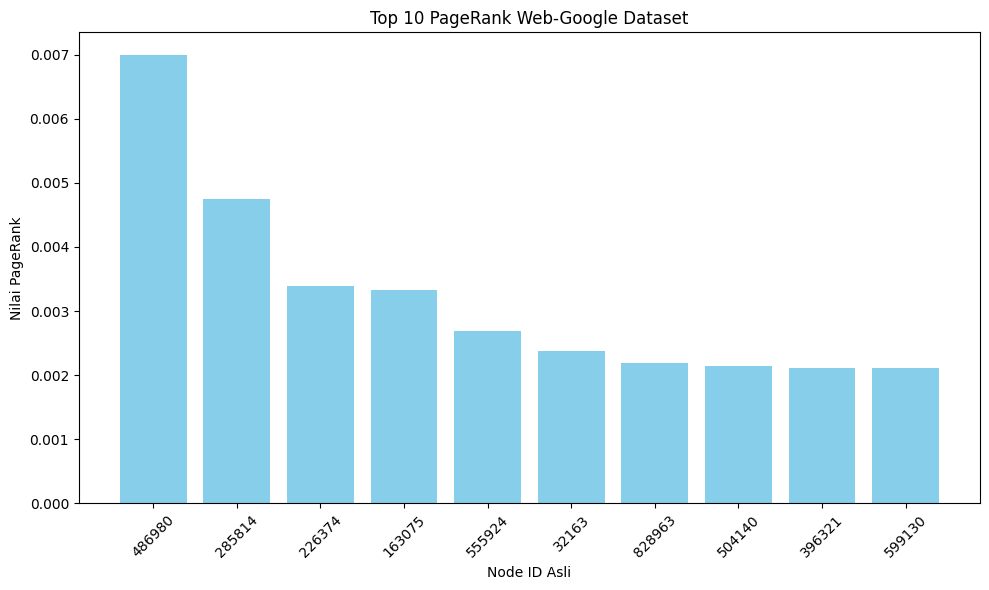

In [14]:
top10 = result.sort_values(by="pagerank", ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.bar(top10['node_id_asli'].astype(str), top10['pagerank'], color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 10 PageRank Web-Google Dataset")
plt.xlabel("Node ID Asli")
plt.ylabel("Nilai PageRank")
plt.tight_layout()
plt.show()